# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Code to make charts and plots interactive, commented out.
#%matplotlib notebook

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy
# For displaying of API data more clearly
from pprint import pprint

# Import API key
from api_keys import weather_api_key

import json

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)



## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=2000)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=2000)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # Capitalizing the first letter of each city word
    city = city.title()
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        
# Print the city count to confirm sufficient count
randomCities = len(cities)
randomCities

784

In [4]:
# Setting up the Dataframe to hold 'cities' values
City_DF = pd.DataFrame(cities)

# Copying original list, in case its needed to be referenced later
CityWeather_DF = City_DF

# Changing first column '0' to 'City' which represents the cities generated
CityWeather_DF = CityWeather_DF.rename(columns={0:"City"})

# Exporting initial 'cities data
CityWeather_DF.to_csv('../output_data/OriginalRandomCities.csv')

# Order of columns in new dataframe that will hold location/weather data will be:
# City Country Lat Lng Max Temp	Humidity Cloudiness Wind Speed  Date
CityWeather_DF.head(20)


,City
0,Labuhan
1,Ondorhaan
2,Neuquen
3,Nikolskoye
4,Faya
5,San Rafael
6,Hithadhoo
7,Avarua
8,Victoria
9,Bluff


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
# SUPPLEMENTAL INFO AND API TESTS

# Creating dynamic URL and checking to see if it works
# Expected output according to API documentation:
# api.openweathermap.org/data/2.5/weather?q={City}&units={unit}&appid={api_key}
# EX) api.openweathermap.org/data/2.5/weather?q=London&units=imperial&appid=APIKEY
# 'units' is 'imperial' for Fahrenheit temp, api key is to be inserted in file "api_keys.py"

# Variables 
#baseURL = "http://api.openweathermap.org/data/2.5/find?q="

#cityName = CityWeather_DF["City"][0]
#cityURL = cityName.replace(" ", "+")
#unitSys = "&units=imperial&appid="

#queryURL = (f'{baseURL}{cityURL}{unitSys}{weather_api_key}') 
#print(queryURL)
#print()

#JsonWeatherResponse = requests.get(queryURL).json()
#pprint(JsonWeatherResponse)


In [6]:
# Start of user facing "data scan"
print()
print(" ----------------------------- ")
print("   BEGINNING DATA RETRIEVAL   ")
print(" ----------------------------- ")
print()

# Index variable to iterate through generated citipy list
nextCity = 0

# Counter to keep track of every 50 succussful city data captures to increase setCounter by 1
recordCounter = 1

# Counter to keep track of how many sets of 50 successful city data captures
setCounter = 1

# Counter to keep track of all times a data API attempt was made (successful or not)
allCityCounter = 1



# For loop to go through however many random cities were generated:
for nextCity in range(randomCities):
   
   # Creating API url dynamically for every city json call/response in city list
   baseURL = "http://api.openweathermap.org/data/2.5/find?q="
   
   # cityName may have spaces""", so removing them for the url link and replacing them with a "+"
   cityName = CityWeather_DF["City"][nextCity]
   
   # using new variable for url to keep the original cityName format for later use in status message
   cityURL = cityName.replace(" ", "+")
   
   unitSys = "&units=imperial&appid="
   queryURL = (f'{baseURL}{cityURL}{unitSys}{weather_api_key}')  
   
   # Copying created API url for current city in another variable to be used in error message
   ReviewURL = queryURL

   JsonWeatherResponse = requests.get(queryURL).json()
   
   # **Reseting Humidity > 100% checker to defauly False
   humidityCheck = False
   


   # Code will try to execute but be cognizant for Exception errors, as well as coded error API checks
   try:

      # recordCounter will reset itself and add 1 to the "Set" display every 50 successful city entries   
      if recordCounter == 51:
         recordCounter = 0
         setCounter += 1

      # if API response returns an incomplete dataset (count=0) 
      # or a dataset with too much data that will errors out (ie count = 5)
      # or webpage returns a cod code/Response other than 200 (ie 404, etc). 
      # this Code will proactively not enter data in and return an error
      # message/update to user with api http. link and continue to process through loop and counts. 
      # These entries/rows will be deleted later 
      if JsonWeatherResponse["count"] > 3 or \
         JsonWeatherResponse["count"] == '0' or \
         JsonWeatherResponse["cod"] != "200":
         
         print()
         print(f'Data for {cityName} is corrupted. Skipping. Can review URL below...')
         print(ReviewURL)
         print()
         
         nextCity += 1
         allCityCounter += 1
         humidityCheck = True

      # Create and populate 9 columns with API data and a humidity check for current city (nextCity/index)
      else:
         CityWeather_DF.loc[nextCity, "Country"] = JsonWeatherResponse['list'][0]["sys"]["country"]
         CityWeather_DF.loc[nextCity, "Lat"] = JsonWeatherResponse['list'][0]["coord"]["lat"]
         CityWeather_DF.loc[nextCity, "Lng"] = JsonWeatherResponse['list'][0]["coord"]["lon"]
         CityWeather_DF.loc[nextCity, "Max Temp"] = JsonWeatherResponse['list'][0]["main"]["temp_max"]
         
         CityWeather_DF.loc[nextCity, "Humidity"] = JsonWeatherResponse['list'][0]["main"]["humidity"]
         # ** Will perform a check on the Humidty value here and "mark it down"
                  
         CityWeather_DF.loc[nextCity, "Cloudiness"] = JsonWeatherResponse['list'][0]["clouds"]["all"]
         CityWeather_DF.loc[nextCity, "Wind Speed"] = JsonWeatherResponse['list'][0]["wind"]["speed"]
         
         # Format data for readability
         CityWeather_DF.loc[nextCity, "Date"] = time.strftime(' %m/%d/%Y', time.localtime(JsonWeatherResponse['list'][0]["dt"]))
         
            # **Perform a check on if Humidity % > 100 (to mark for deletion later)
            # Assigning value to a new column to track
         if CityWeather_DF["Humidity"][nextCity] >= 100.00:
            humidityCheck = True
            CityWeather_DF.loc[nextCity, "Humidity > 100%"] = humidityCheck
         else:
            humidityCheck = False
            CityWeather_DF.loc[nextCity, "Humidity > 100%"] = humidityCheck
            # 'True' columned cities will have their data/ROWS deleted later in a new DF
            # 'False' columned cities wll retain original data. New column will then be deleted during clean
         
         # Message progress detailing number of successful sets, all attempts vs full list, and the city       
         print(f"Processing Record.. { recordCounter } of Set { setCounter }  ({allCityCounter} / {randomCities})   |   {cityName}")

         # Iterate counts
         nextCity += 1
         recordCounter += 1
         allCityCounter += 1
            
      # In the event of an indexerror/incomplet API, no data will be marked and loop/count will be iterated   
   except IndexError:
      print()
      print(f'No Data for {cityName}. Skipping entry...')
      print()
      allCityCounter += 1
      nextCity += 1
      pass

# End of "data scan"
print()
print(" ----------------------------- ")
print("   DATA RETRIEVAL COMPLETE   ")
print(" ----------------------------- ")
print()

# My API key will show in the outputs, but it will be deactivated and deleted. To run a test of your own, a new key will have to be registered at: https://home.openweathermap.org/ and saved in this code's directory "api_keys.py" file.


 ----------------------------- 
   BEGINNING DATA RETRIEVAL   
 ----------------------------- 

Processing Record.. 1 of Set 1  (1 / 784)   |   Labuhan

No Data for Ondorhaan. Skipping entry...

Processing Record.. 2 of Set 1  (3 / 784)   |   Neuquen

Data for Nikolskoye is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=Nikolskoye&units=imperial&appid=8f818372da0128048522d56de3aaa224

Processing Record.. 3 of Set 1  (5 / 784)   |   Faya

Data for San Rafael is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=San+Rafael&units=imperial&appid=8f818372da0128048522d56de3aaa224

Processing Record.. 4 of Set 1  (7 / 784)   |   Hithadhoo
Processing Record.. 5 of Set 1  (8 / 784)   |   Avarua

Data for Victoria is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=Victoria&units=imperial&appid=8f818372da0128048522d56de3aaa224

Processing Record.. 6 of Set 1  (10 / 784) 

In [7]:
# Display column counts, calculations overview (including max values ie "Humidity"), and dataframe preview
print(CityWeather_DF.count())
print()
print()
print(CityWeather_DF.describe())
print()
print()
CityWeather_DF.head(20)

City               784
Country            642
Lat                642
Lng                642
Max Temp           642
Humidity           642
Cloudiness         642
Wind Speed         642
Date               642
Humidity > 100%    642
dtype: int64


              Lat         Lng    Max Temp    Humidity  Cloudiness  Wind Speed
count  642.000000  642.000000  642.000000  642.000000  642.000000  642.000000
mean    19.976558   23.542410   54.060841   72.171340   53.568536    7.979315
std     33.731080   89.262068   28.538520   21.269944   39.459916    5.750785
min    -54.800000 -179.166700  -33.000000   13.000000    0.000000    0.340000
25%     -8.738200  -55.624300   33.800000   61.000000   14.250000    3.780000
50%     22.622500   27.821200   62.690000   77.500000   63.500000    6.910000
75%     49.227125  103.316250   77.887500   88.000000   91.000000   10.705000
max     78.218600  179.316700  101.890000  100.000000  100.000000   51.790000




,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date,Humidity > 100%
0,Labuhan,ID,-6.8844,112.2051,77.92,84.0,4.0,3.69,03/15/2021,False
1,Ondorhaan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Neuquen,AR,-38.9516,-68.0591,89.60,31.0,20.0,3.44,03/15/2021,False
3,Nikolskoye,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Faya,SA,18.3851,42.4509,66.20,67.0,0.0,3.44,03/15/2021,False
5,San Rafael,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Hithadhoo,MV,-0.6000,73.0833,83.48,64.0,91.0,6.62,03/15/2021,False
7,Avarua,CK,-21.2078,-159.7750,78.80,94.0,20.0,8.05,03/15/2021,False
8,Victoria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bluff,NZ,-46.6000,168.3333,48.00,91.0,88.0,7.00,03/15/2021,False


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
# _______ CityWeather_DF _______
# Clean the data of any blanks, duplicates, or rows with null/NaN values.
CityWeather_DF.replace("", np.nan, inplace=True)
CityWeather_DF.replace("NaN", np.nan, inplace=True)
CityWeather_DF = CityWeather_DF.drop_duplicates()
CityWeather_DF = CityWeather_DF.dropna()
# Check to see if all rows have the same count and dataframe preview.
#print(CityWeather_DF.count())
#print()
#CityWeather_DF.head(20)


# Create new copy of dataframe. 
clean_city_dataDF = CityWeather_DF.copy()
# ** See next code snippet regarding new "100% Humidity" DF

# Once the copy is complete, the orignal dataframe will be cleaned of the extra ["Humidity > 100%"] row
# Displaying cleaned "original/spaceless" DF
del CityWeather_DF["Humidity > 100%"]
print(CityWeather_DF.count())
print()
CityWeather_DF.head(20)


City          642
Country       642
Lat           642
Lng           642
Max Temp      642
Humidity      642
Cloudiness    642
Wind Speed    642
Date          642
dtype: int64



,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Labuhan,ID,-6.8844,112.2051,77.92,84.0,4.0,3.69,03/15/2021
2,Neuquen,AR,-38.9516,-68.0591,89.60,31.0,20.0,3.44,03/15/2021
4,Faya,SA,18.3851,42.4509,66.20,67.0,0.0,3.44,03/15/2021
6,Hithadhoo,MV,-0.6000,73.0833,83.48,64.0,91.0,6.62,03/15/2021
7,Avarua,CK,-21.2078,-159.7750,78.80,94.0,20.0,8.05,03/15/2021
9,Bluff,NZ,-46.6000,168.3333,48.00,91.0,88.0,7.00,03/15/2021
11,Keetmanshoop,NA,-26.5833,18.1333,77.00,29.0,28.0,13.80,03/15/2021
12,Bubaque,GW,11.2833,-15.8333,79.14,62.0,17.0,19.46,03/15/2021
13,Haines Junction,CA,60.7522,-137.5108,12.20,57.0,100.0,1.14,03/15/2021
14,Khatanga,RU,71.9667,102.5000,-23.04,87.0,100.0,9.46,03/15/2021


In [9]:
# _______ clean_city_dataDF _______
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.

# **This DF copy will be cleaned further of cities with +100% humidty by removing rows of True
clean_city_dataDF = clean_city_dataDF[clean_city_dataDF["Humidity > 100%"] != True]
# And then Humidity column itself and display DF summary
del clean_city_dataDF["Humidity > 100%"]
print(clean_city_dataDF.count())
print()
clean_city_dataDF.head(20)

City          628
Country       628
Lat           628
Lng           628
Max Temp      628
Humidity      628
Cloudiness    628
Wind Speed    628
Date          628
dtype: int64



,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Labuhan,ID,-6.8844,112.2051,77.92,84.0,4.0,3.69,03/15/2021
2,Neuquen,AR,-38.9516,-68.0591,89.60,31.0,20.0,3.44,03/15/2021
4,Faya,SA,18.3851,42.4509,66.20,67.0,0.0,3.44,03/15/2021
6,Hithadhoo,MV,-0.6000,73.0833,83.48,64.0,91.0,6.62,03/15/2021
7,Avarua,CK,-21.2078,-159.7750,78.80,94.0,20.0,8.05,03/15/2021
9,Bluff,NZ,-46.6000,168.3333,48.00,91.0,88.0,7.00,03/15/2021
11,Keetmanshoop,NA,-26.5833,18.1333,77.00,29.0,28.0,13.80,03/15/2021
12,Bubaque,GW,11.2833,-15.8333,79.14,62.0,17.0,19.46,03/15/2021
13,Haines Junction,CA,60.7522,-137.5108,12.20,57.0,100.0,1.14,03/15/2021
14,Khatanga,RU,71.9667,102.5000,-23.04,87.0,100.0,9.46,03/15/2021


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [10]:
# Summary display of CityWeather_DF dataframe and export to .csv
print(CityWeather_DF.count())
print()

print(CityWeather_DF.describe())
print()

CityWeather_DF.to_csv('../output_data/CityWeather.csv')
print(CityWeather_DF.head(20))
print()


City          642
Country       642
Lat           642
Lng           642
Max Temp      642
Humidity      642
Cloudiness    642
Wind Speed    642
Date          642
dtype: int64

              Lat         Lng    Max Temp    Humidity  Cloudiness  Wind Speed
count  642.000000  642.000000  642.000000  642.000000  642.000000  642.000000
mean    19.976558   23.542410   54.060841   72.171340   53.568536    7.979315
std     33.731080   89.262068   28.538520   21.269944   39.459916    5.750785
min    -54.800000 -179.166700  -33.000000   13.000000    0.000000    0.340000
25%     -8.738200  -55.624300   33.800000   61.000000   14.250000    3.780000
50%     22.622500   27.821200   62.690000   77.500000   63.500000    6.910000
75%     49.227125  103.316250   77.887500   88.000000   91.000000   10.705000
max     78.218600  179.316700  101.890000  100.000000  100.000000   51.790000

               City Country      Lat       Lng  Max Temp  Humidity  \
0           Labuhan      ID  -6.8844  112.2051     

In [11]:
# Summary display of clean_city_dataDF dataframe and export to .csv
print(clean_city_dataDF.count())
print()

print(clean_city_dataDF.describe())
print()

clean_city_dataDF.to_csv('../output_data/CleanCityWeatherData.csv')
print(clean_city_dataDF.head(20))
print()


City          628
Country       628
Lat           628
Lng           628
Max Temp      628
Humidity      628
Cloudiness    628
Wind Speed    628
Date          628
dtype: int64

              Lat         Lng    Max Temp    Humidity  Cloudiness  Wind Speed
count  628.000000  628.000000  628.000000  628.000000  628.000000  628.000000
mean    20.039227   23.005024   54.063455   71.550955   53.162420    7.916274
std     33.605567   89.334656   28.747419   21.091105   39.559203    5.485901
min    -54.800000 -179.166700  -33.000000   13.000000    0.000000    0.340000
25%     -8.506650  -56.723950   33.235000   61.000000   14.000000    3.775000
50%     22.622500   27.821200   63.240000   77.000000   62.000000    6.910000
75%     49.191650  102.628725   78.010000   88.000000   92.000000   10.745000
max     78.218600  179.316700  101.890000   99.000000  100.000000   40.290000

               City Country      Lat       Lng  Max Temp  Humidity  \
0           Labuhan      ID  -6.8844  112.2051     

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


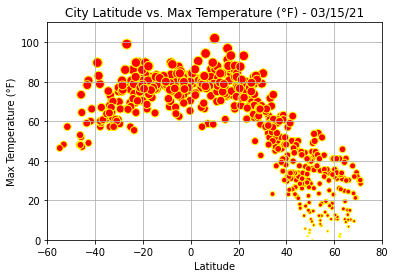

 Based on our 'Latitude vs. Max Temperature' scatter plot, we can see that as one gets closer to the equator (0) from the Ssouth, the temperature arches upwards in a curve to reflect the rise in temperature before trending down as we move away north from the equator's latitude. Interestingly, the highest temperature are not exactly at the equator but rather off approximately 20 degrees north and south of the Equator. (Highest temperatures recorded were approximately 30 degrees South.)


In [12]:
# Latitude vs. Max Temperature Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Max Temp"], facecolor="red", edgecolors="yellow",
           s=clean_city_dataDF["Max Temp"])
plt.title("City Latitude vs. Max Temperature (°F) - 03/15/21")
plt.grid()

plt.xlim(-60,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (°F)")
plt.savefig("../Images/Lat_vs_MaxTemp.jpg", dpi=200)
plt.show()

print(" Based on our 'Latitude vs. Max Temperature' scatter plot, we can see that as one gets closer to the equator (0) from the South, the temperature arches upwards in a curve to reflect the rise in temperature before trending down as we move away north from the equator's latitude. Interestingly, the highest temperature are not exactly at the equator but rather off approximately 20 degrees north and south of the Equator.")

## Latitude vs. Humidity Plot

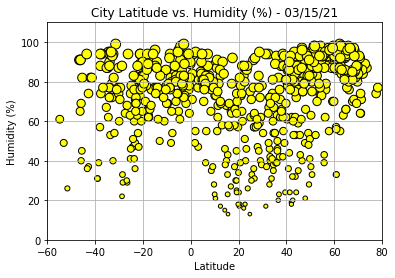

 There doesn't seem to be any discernable pattern or relation between Humidity and the Latitude. The humidity % is uniformly scattered, and generally above 60%, no matter how close or far away from the Equator you are.


In [13]:
# Latitude vs. Humidity Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Humidity"], facecolor="yellow", edgecolors="black",
           alpha=1, s=clean_city_dataDF["Humidity"])

plt.title("City Latitude vs. Humidity (%) - 03/15/21")
plt.grid()

plt.xlim(-60,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("../Images/Lat_vs_Humidity.jpg", dpi=200)
plt.show()

print(" There doesn't seem to be any discernable pattern or relation between Humidity and the Latitude. The humidity % is uniformly scattered, and generally above 60%, no matter how close or far away from the Equator you are.")

## Latitude vs. Cloudiness Plot

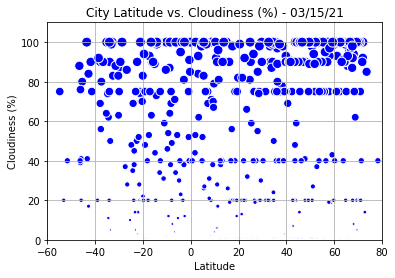

 Just as with the observations regarding Humidity vs Latitude, there seems to be no pattern or trend to signify a direct correlation between Cloudiness and Latitude. Many cities seem to share a high percentage/concentration of cloudiness the world over.


In [14]:
# Latitude vs. Cloudiness Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Cloudiness"], facecolor="blue", edgecolors="white",
           alpha=1, s=clean_city_dataDF["Cloudiness"])

plt.title("City Latitude vs. Cloudiness (%) - 03/15/21")
plt.grid()

plt.xlim(-60,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig("../Images/Lat_vs_Cloudiness.jpg", dpi=200)
plt.show()

print(" Just as with the observations regarding Humidity vs Latitude, there seems to be no pattern or trend to signify a direct correlation between Cloudiness and Latitude. Many cities seem to share a high percentage/concentration of cloudiness the world over.")

## Latitude vs. Wind Speed Plot

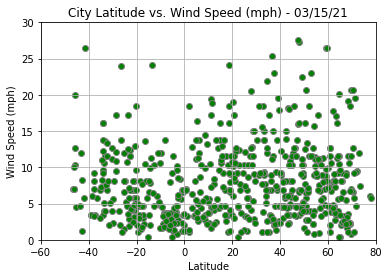

The only observation I can see is, more generally, the low wind speed across most cities. The wind speed doesn't really go too much past 20mph, on the high end, regardless of latitude and equatorial distance. The concentration of wind speed seem to be around 5-10 mph today. If any, there are higher wind speed toward the extreme North vs extreme South.


In [15]:
# Latitude vs. Wind Speed Plot


plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Wind Speed"], facecolor="green", edgecolors="gray",
           alpha=1)

plt.title("City Latitude vs. Wind Speed (mph) - 03/15/21")
plt.grid()

plt.xlim(-60,80)
plt.ylim(0,30)

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig("../Images/Lat_vs_WindSpeed.jpg", dpi=200)
plt.show()

print("The only observation I can see is, more generally, the low wind speed across most cities. The wind speed doesn't really go too much past 20mph, on the high end, regardless of latitude and equatorial distance. The concentration of wind speed seem to be around 3-8 mph today. If any, there are higher wind speed toward the extreme North vs extreme South.")

## Linear Regression

In [16]:
# Must separate the plots into a Northern Hemisphere (greater than or equal to 0 degrees latitude) and a Southern Hemisphere (less than 0 degrees latitude) dataframe grouping. Referencing 'Humidity>100%' check code: CityWeather_DF.loc[nextCity, "Humidity > 100%"] = CityWeather_DF["Humidity"][nextCity] >= 100.00:
# Northern Hemispheres Cities
NorthernHemi_DF = clean_city_dataDF.loc[clean_city_dataDF["Lat"] >= 0]
NorthernHemi_DF.head(20) # Test to see if returned Latitude values are > 0, Lat should be positive
#clean_city_dataDF.head(20) # Compare results to normal dataframe, if need.

,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
4,Faya,SA,18.3851,42.4509,66.20,67.0,0.0,3.44,03/15/2021
12,Bubaque,GW,11.2833,-15.8333,79.14,62.0,17.0,19.46,03/15/2021
13,Haines Junction,CA,60.7522,-137.5108,12.20,57.0,100.0,1.14,03/15/2021
14,Khatanga,RU,71.9667,102.5000,-23.04,87.0,100.0,9.46,03/15/2021
18,Kapaa,US,22.0752,-159.3190,73.40,83.0,40.0,9.22,03/15/2021
22,Coahuayana,MX,18.7333,-103.6833,84.20,30.0,1.0,6.91,03/15/2021
25,Avera,US,33.1940,-82.5271,71.60,40.0,90.0,14.97,03/15/2021
27,Saskylakh,RU,71.9167,114.0833,-24.11,84.0,92.0,4.65,03/15/2021
29,Urengoy,RU,65.9667,78.3667,6.64,95.0,92.0,8.16,03/15/2021
30,Buraydah,SA,26.3260,43.9750,78.80,36.0,40.0,6.91,03/15/2021


In [17]:
# Southern Hemispheres Cities
SouthernHemi_DF = clean_city_dataDF.loc[clean_city_dataDF["Lat"] <= 0]
SouthernHemi_DF.head(20) # Test to see if returned Latitude values are < 0, Lat should be negative
#clean_city_dataDF.head(20) # Compare results to normal dataframe, if need.

,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Labuhan,ID,-6.8844,112.2051,77.92,84.0,4.0,3.69,03/15/2021
2,Neuquen,AR,-38.9516,-68.0591,89.60,31.0,20.0,3.44,03/15/2021
6,Hithadhoo,MV,-0.6000,73.0833,83.48,64.0,91.0,6.62,03/15/2021
7,Avarua,CK,-21.2078,-159.7750,78.80,94.0,20.0,8.05,03/15/2021
9,Bluff,NZ,-46.6000,168.3333,48.00,91.0,88.0,7.00,03/15/2021
11,Keetmanshoop,NA,-26.5833,18.1333,77.00,29.0,28.0,13.80,03/15/2021
15,Luziania,BR,-16.2525,-47.9503,72.00,88.0,90.0,8.05,03/15/2021
20,Omboue,GA,-1.5746,9.2618,75.27,91.0,100.0,5.57,03/15/2021
23,Porto Walter,BR,-8.2686,-72.7439,89.60,49.0,69.0,3.09,03/15/2021
24,Punta Arenas,CL,-53.1500,-70.9167,48.20,49.0,20.0,31.07,03/15/2021


In [18]:
# Linear Regression formula is going to be: 
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# Will need variables for x/y _values which will be the hemisphere dataframes': 
# Lat vs. Max Temp / Humidity / Cloudiness / Wind Speed 

# Referencing class exercise on Regression for code:
    # x_values = _DF["xxx"]
    # y_values = _DF["xxx"]
    # (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    # regress_values = x_values * slope + intercept
    # line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # plt.scatter(x_values,y_values)
    # plt.plot(x_values,regress_values,"r-")
    # plt.annotate(line_eq,(6,10),fontsize=15,color="red")
    # plt.xlabel('xxx')
    # plt.ylabel('xxx')
    # print(f"The r-squared is: {rvalue**2}")
    # plt.show()

# Will plug in values/columns and reuse code format to keep charts consistent

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7779388311612973


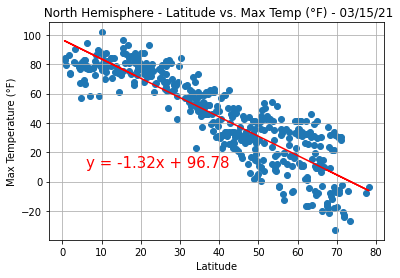

There is a negative linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other decreases. Note: Correlation is not the same as causation.


In [19]:

plt.title(" North Hemisphere - Latitude vs. Max Temp (°F) - 03/15/21")

plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/MaxTemp_vs_Lat_NorthHemi.jpg", dpi=200)
plt.show()
print("There is a negative linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other decreases. Note: Correlation is not the same as causation.")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.3312571208554729


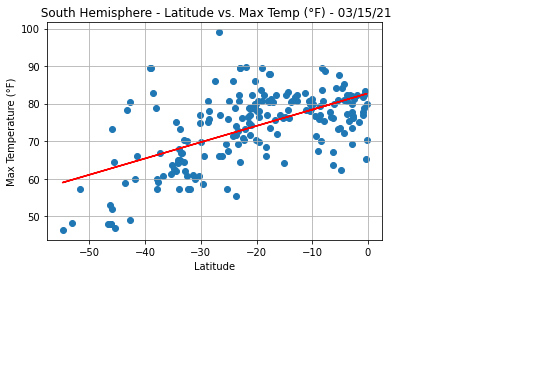

There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.


In [20]:

plt.title(" South Hemisphere - Latitude vs. Max Temp (°F) - 03/15/21")

plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
print(f"The r-squared is: {rvalue**2}")


plt.savefig("../Images/MaxTemp_vs_Lat_SouthHemi.jpg", dpi=200)
plt.show()
print("There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.13395426284046527


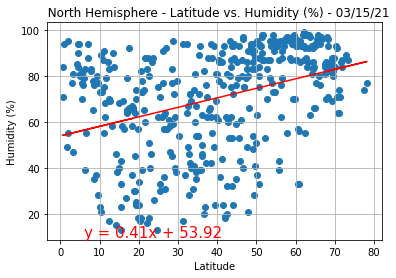

There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.


In [21]:

plt.title("  North Hemisphere - Latitude vs. Humidity (%) - 03/15/21")

plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/Humidity_vs_Lat_NorthHemi.jpg", dpi=200)
plt.show()
print("There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.07626875666237962


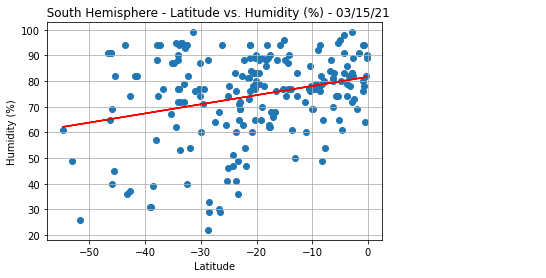

The linear regression line is flat, and not sloped really, indicating there is no relationship between the two variables. Note: Correlation is not the same as causation.


In [22]:

plt.title("  South Hemisphere - Latitude vs. Humidity (%) - 03/15/21")

plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/Humidity_vs_Lat_SouthHemi.jpg", dpi=200)
plt.show()
print("There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.051912026556750854


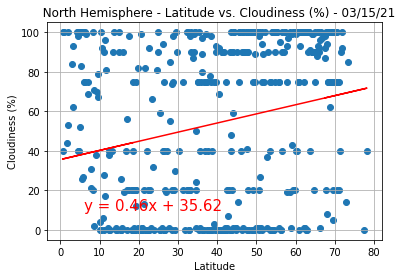

There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.


In [23]:

plt.title("  North Hemisphere - Latitude vs. Cloudiness (%) - 03/15/21")

plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/Cloudiness_vs_Lat_NorthHemi.jpg", dpi=200)
plt.show()
print("There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.024517158496609685


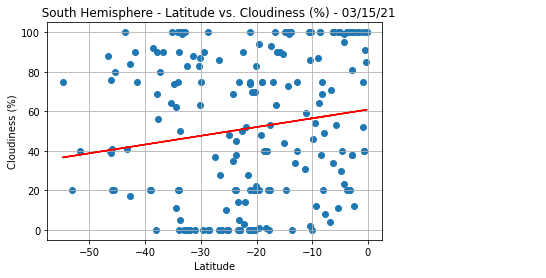

The linear regression line is pretty much flat, and not sloped really, indicating there is likely no relationship between the two variables, at best it is very slight. Note: Correlation is not the same as causation.


In [24]:

plt.title("  South Hemisphere - Latitude vs. Cloudiness (%) - 03/15/21")

plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/Cloudiness_vs_Lat_SouthHemi.jpg", dpi=200)
plt.show()
print("There is a positive linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other also increases. Note: Correlation is not the same as causation.")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 5.228300417155868e-06


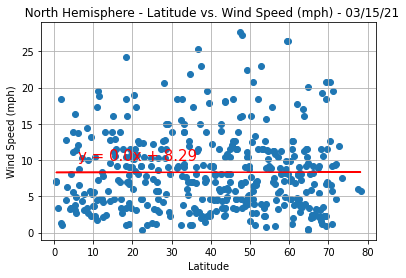

The linear regression line is flat, and not sloped really, indicating there is no relationship between the two variables. Note: Correlation is not the same as causation.


In [25]:

plt.title("  North Hemisphere - Latitude vs. Wind Speed (mph) - 03/15/21")

plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/WindSpeed_vs_Lat_NorthHemi.jpg", dpi=200)
plt.show()
print("The linear regression line is flat, and not sloped really, indicating there is no relationship between the two variables. Note: Correlation is not the same as causation.")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.18673129552895892


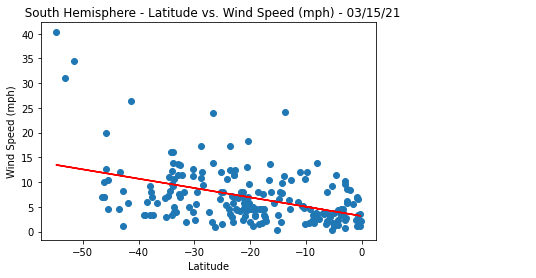

There is a negative linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other decreases. Note: Correlation is not the same as causation.


In [26]:

plt.title("  South Hemisphere - Latitude vs. Wind Speed (mph) - 03/15/21")

x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")

plt.savefig("../Images/WindSpeed_vs_Lat_SouthHemi.jpg", dpi=200)
plt.show()
print("There is a negative linear relationship/regression line between the two variables/axis: as the value of one increases, the value of the other decreases. Note: Correlation is not the same as causation.")